### Hyperparametros

In [1]:
import ast

results = open("./../models/Glass_models/results.txt", "r")
results = results.readlines()
count = 0
results_dict = {}
for line in results:
    line = line.strip("\n")
    line_by_spaces = line.split(" ")
    if line_by_spaces[0] == "Batch":
        line_by_comas = line.split(",")
        settings = {}
        for item in line_by_comas:
            setting = item.strip(" ").split(":")
            settings[setting[0]] = float(setting[1].strip(" ")) 
        results_dict[count] = settings
    if line_by_spaces[0] == "Mean":
        results = line.strip("Mean performance of 5 folds:")
        results = ast.literal_eval(results)
        combined_results = {}
        for key in results:
            for value in results[key]:
                new_key = key + "_" + value
                combined_results[new_key] = results[key][value]
        results_dict[count] = results_dict[count] | combined_results
        count += 1

print(results_dict)

{0: {'Batch size': 2.0, 'Learning rate': 0.001, 'Batch size per image': 64.0, 'bbox_AP': 6.9807808979049835, 'bbox_AP50': 11.868769454410875, 'bbox_AP75': 7.72875520032247, 'bbox_APs': 7.377988827904494, 'bbox_APm': 9.078417403725513, 'bbox_APl': 12.011808010709444, 'bbox_AP-dark': 5.20887670274747, 'bbox_AP-light': 8.752685093062496, 'segm_AP': 2.284272126928159, 'segm_AP50': 7.832799319194043, 'segm_AP75': 0.45816440583650914, 'segm_APs': 1.819532716247044, 'segm_APm': 16.985378920632332, 'segm_APl': 4.319526952695268, 'segm_AP-dark': 2.021599151890119, 'segm_AP-light': 2.546945101966198}, 1: {'Batch size': 2.0, 'Learning rate': 0.001, 'Batch size per image': 128.0, 'bbox_AP': 8.634869863199302, 'bbox_AP50': 13.293690031622063, 'bbox_AP75': 10.16334292565567, 'bbox_APs': 8.92224855015143, 'bbox_APm': 10.747758121356979, 'bbox_APl': 13.40880991535062, 'bbox_AP-dark': 7.171255956836203, 'bbox_AP-light': 10.098483769562401, 'segm_AP': 2.9264125166589645, 'segm_AP50': 8.992628899633468, 

In [2]:
import pandas as pd

df = pd.DataFrame.from_dict(results_dict, orient='index')
df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
0,2.0,0.0010,64.0,6.980781,11.868769,7.728755,7.377989,9.078417,12.011808,5.208877,8.752685,2.284272,7.832799,0.458164,1.819533,16.985379,4.319527,2.021599,2.546945
1,2.0,0.0010,128.0,8.634870,13.293690,10.163343,8.922249,10.747758,13.408810,7.171256,10.098484,2.926413,8.992629,0.595275,1.998273,16.500894,5.947030,2.556020,3.296805
2,2.0,0.0010,256.0,9.298117,13.923882,10.758355,8.941805,13.504626,13.763830,8.032503,10.563731,3.285799,10.334963,0.813432,2.183651,16.354310,6.434743,3.073200,3.498398
3,2.0,0.0010,512.0,6.881601,10.336258,7.473847,6.763451,9.472617,11.511264,4.546544,9.216658,2.318847,6.956063,0.696015,1.316803,18.652966,6.766557,1.679336,2.958357
4,2.0,0.0001,64.0,5.863682,9.847576,6.047921,5.533947,8.647506,7.259573,3.463371,8.263992,1.577873,5.225722,0.272877,1.059703,13.106490,1.760635,0.816952,2.338793


In [3]:
df_sorted = df.sort_values(by=['bbox_AP','segm_AP'], ascending=False)
df_sorted.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
49,10.0,0.001,128.0,10.836327,15.401072,12.237261,10.055775,13.721033,16.103348,9.826027,11.846627,3.907506,10.603062,1.801154,3.424632,21.358359,6.907591,3.916477,3.898535
38,8.0,0.001,256.0,10.238143,14.640276,11.636960,10.280377,13.253589,16.100526,8.665789,11.810498,3.652058,10.310902,1.339706,2.231816,22.395318,5.877888,3.016289,4.287827
50,10.0,0.001,256.0,10.177159,14.762258,11.715184,9.834187,13.122162,15.210139,9.110928,11.243389,3.539579,10.057012,1.098074,2.395174,22.457839,6.836634,3.195094,3.884064
48,10.0,0.001,64.0,10.069569,14.569697,11.452023,9.776804,12.634998,16.770460,8.924474,11.214663,3.548093,10.169025,0.995762,2.826260,21.068299,6.282885,3.489007,3.607179
26,6.0,0.001,256.0,9.974337,14.570267,11.713180,9.612261,13.613043,16.743252,8.649182,11.299491,3.564611,10.451672,0.992449,2.347018,20.408957,7.242574,3.071767,4.057454


The best models are 49 and 38, however performance is realy close and the difference is not super significant. We will need to further investigate the trends to see which one is better.

In [4]:
reduces_df = df[['Batch size', 'Learning rate', 'Batch size per image','bbox_AP', 'segm_AP']]
reduces_df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,segm_AP
0,2.0,0.0010,64.0,6.980781,2.284272
1,2.0,0.0010,128.0,8.634870,2.926413
2,2.0,0.0010,256.0,9.298117,3.285799
3,2.0,0.0010,512.0,6.881601,2.318847
4,2.0,0.0001,64.0,5.863682,1.577873


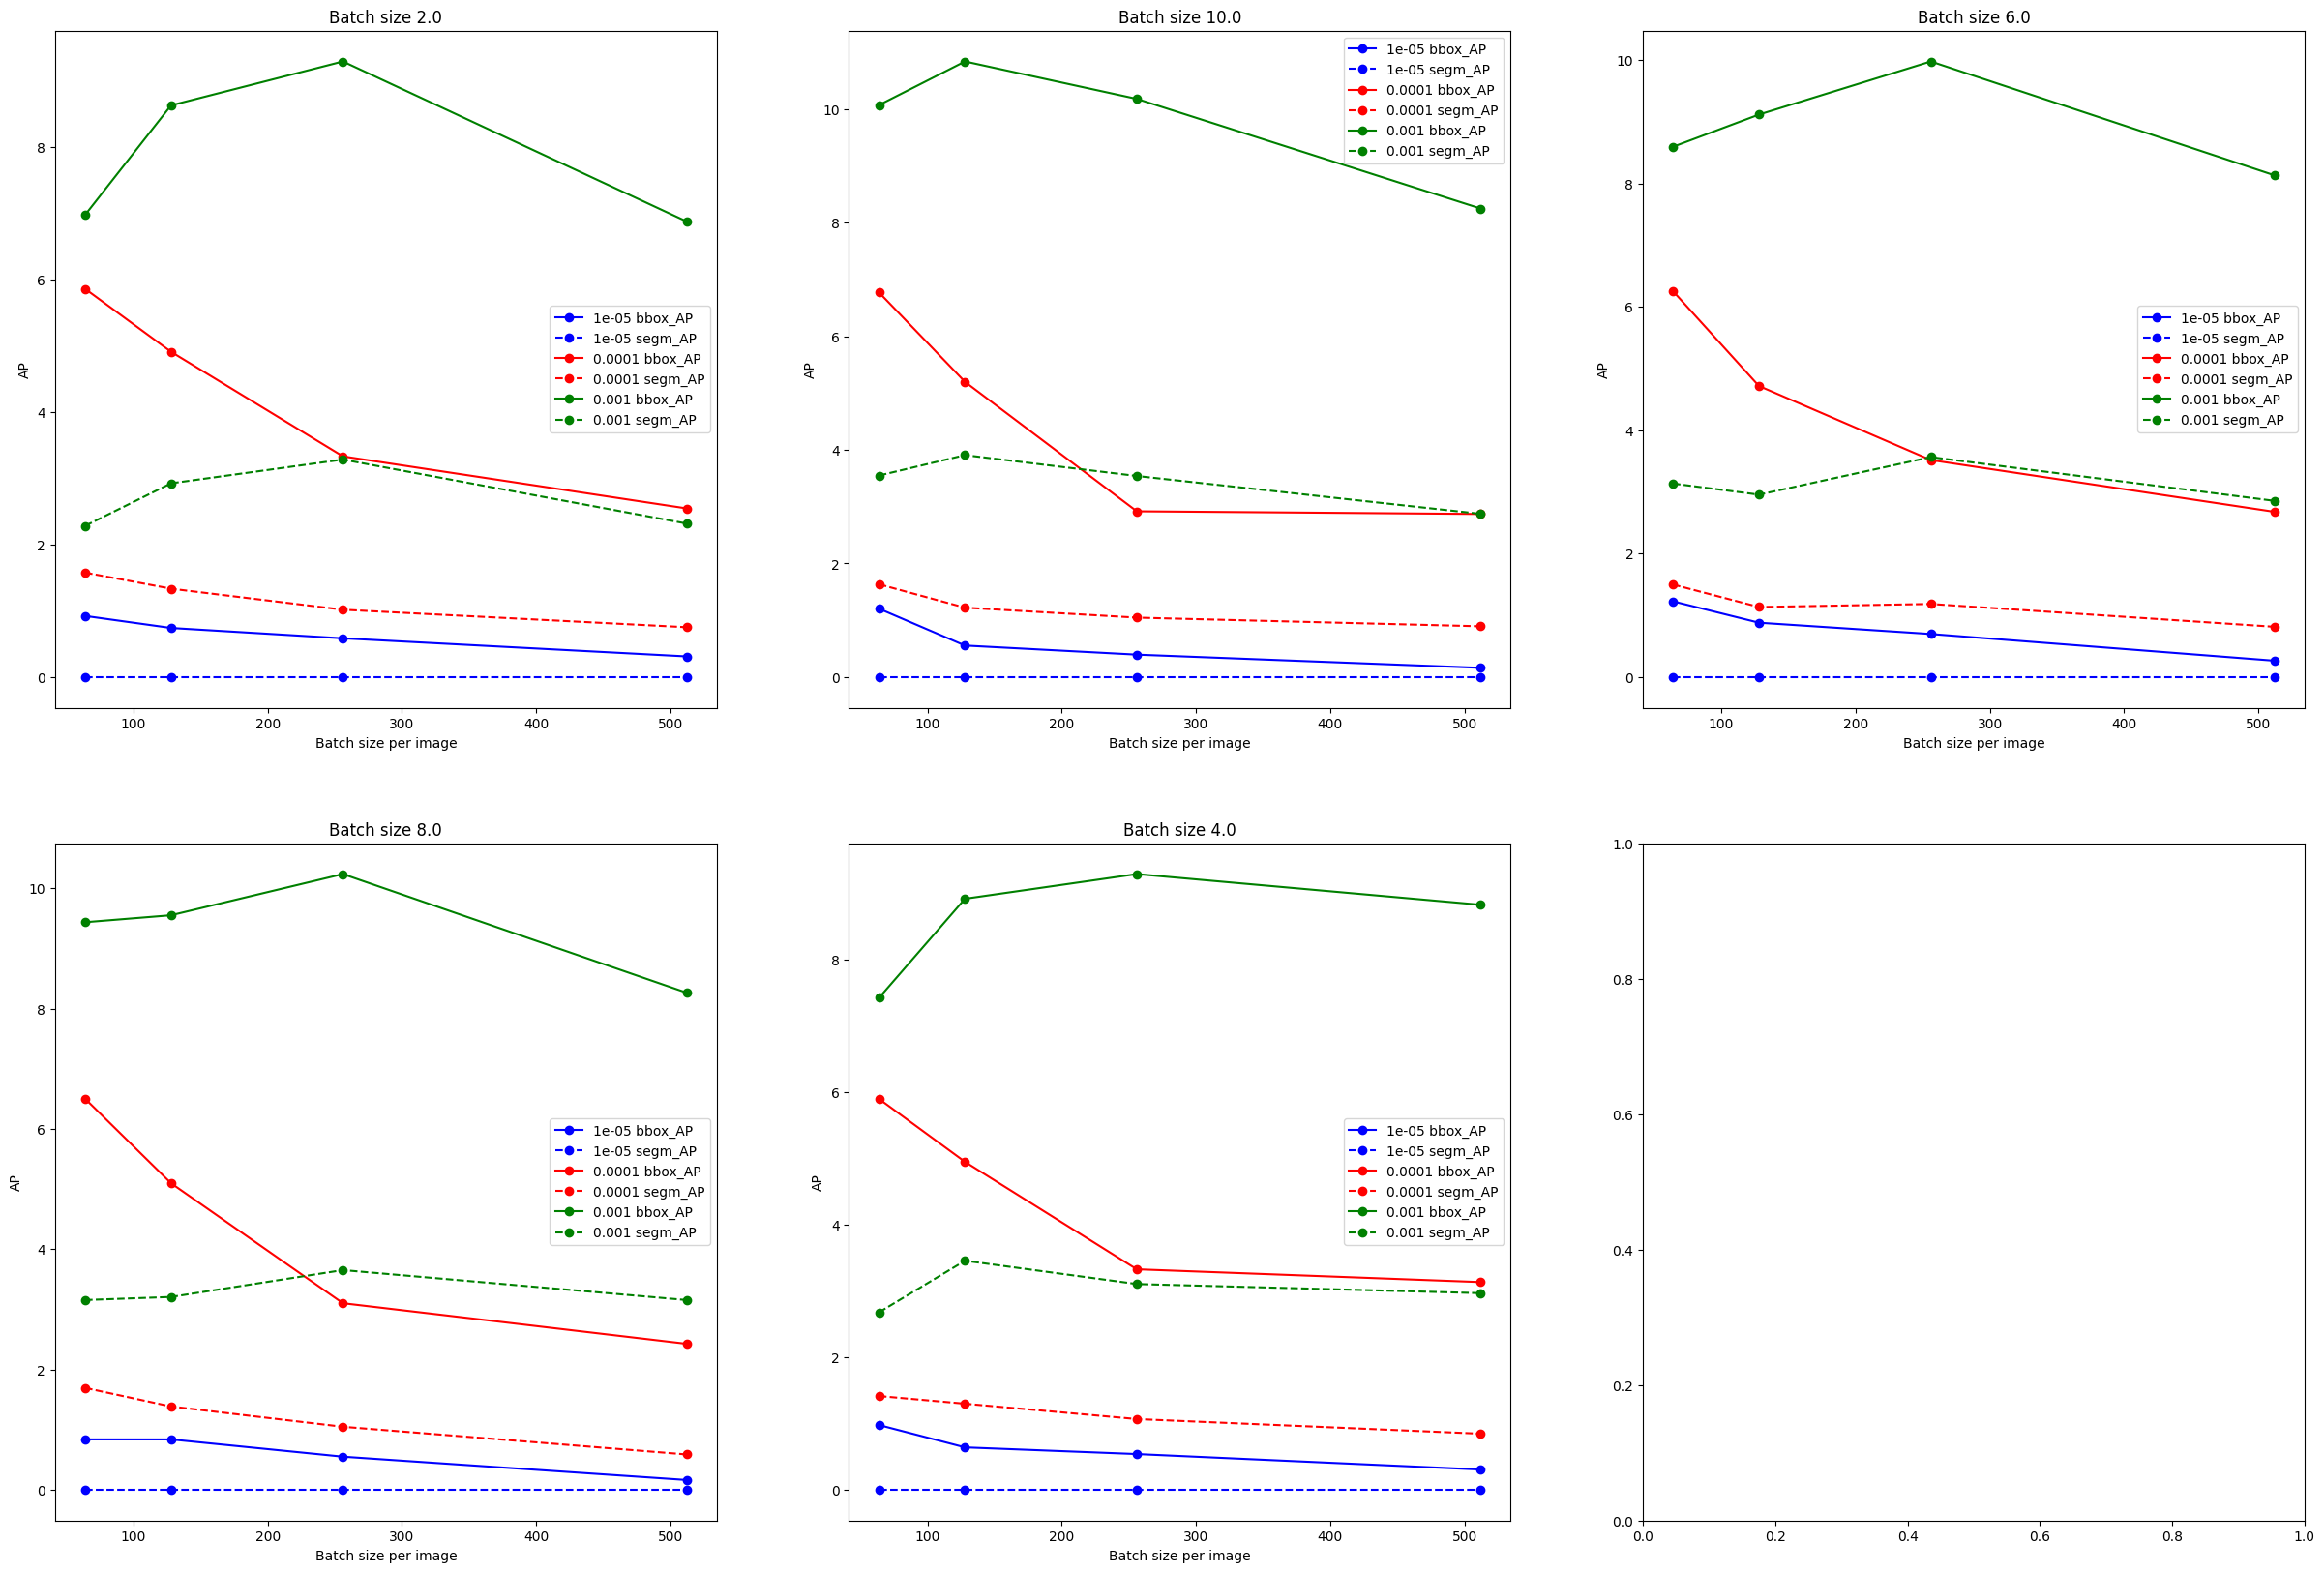

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_bs = reduces_df.groupby('Batch size')

fig, ax = plt.subplots(2,3, figsize=(30, 20))

# Define line styles
line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green']

for i,(key, group) in enumerate(grouped_bs):
    if key in [2.0, 4.0, 6.0, 8.0, 10.0]:
        grouped_lr = group.groupby('Learning rate')
        for j,(key_lr, group_lr) in enumerate(grouped_lr):
            for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
                ax[i%2][i%3].plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
        ax[i%2][i%3].legend()
        ax[i%2][i%3].set_title(f'Batch size {key}')
        ax[i%2][i%3].set_xlabel('Batch size per image')
        ax[i%2][i%3].set_ylabel('AP')

plt.show()



The most relevant graphs are the ones with batch size of 6,8,10 as they yield the best results, more particularly 8 and 10. From 8 and 10 the same tendeny related to tuhe learning reate apear, as it shows that the best learning rate is 0.001. Within this lr, there are same similarities within the bspi, as bs=8.0 the best bs is 256 and higher value gets way worse results, and lower also worst but less significant. For bs=10.0 the best bs is 128, and the same trend is observed. So the ideal bspi looks between 128 and 256.

### Folds

In [6]:
import re

def get_results(data):
    keys = ["bbox_AP", "segm_AP"]
    results = {}
    matches = re.findall(r'{.*?}', data)
    for i,match in enumerate(matches):
        match = ast.literal_eval(match)
        results[keys[i]] = match
    return results

In [7]:
results = open("./../models/Glass_models/results.txt", "r")
results = results.readlines()
count = 0
data_dict = {}

for i, line in enumerate(results):
    line = line.strip("\n")
    if line == str(count):
        data_list = results[i+3:i+8]
        data_len = len(data_list)
        data = [d.split("OrderedDict")[1] for d in data_list]
        results_to_dict = [get_results(d) for d in data]
        fold_dict = {}
        for i, r in enumerate(results_to_dict):
            fold_dict[i] = r
        data_dict[count] = fold_dict
        count += 1

print(data_dict)

{0: {0: {'bbox_AP': {'AP': 5.5919116144515195, 'AP50': 10.313265549339514, 'AP75': 6.523037041974468, 'APs': 4.380451299458231, 'APm': 7.015467681156018, 'APl': 13.206282992770799, 'AP-dark': 2.7539178784394465, 'AP-light': 8.429905350463592}, 'segm_AP': {'AP': 1.1673431292485053, 'AP50': 4.759985485981561, 'AP75': 0.13673488641896453, 'APs': 0.8516910761130484, 'APm': 19.896273054670004, 'APl': 0.34653465346534645, 'AP-dark': 1.3124825334727905, 'AP-light': 1.02220372502422}}, 1: {'bbox_AP': {'AP': 7.28071527726369, 'AP50': 11.997044525177875, 'AP75': 7.541373966481693, 'APs': 7.77148529804338, 'APm': 11.224987280473284, 'APl': 10.06699254963484, 'AP-dark': 7.669303371449001, 'AP-light': 6.892127183078377}, 'segm_AP': {'AP': 2.727889778889432, 'AP50': 8.526030708713197, 'AP75': 1.1691507874191214, 'APs': 2.177533369309651, 'APm': 14.754690840192128, 'APl': 3.0346534653465347, 'AP-dark': 2.4665774208336986, 'AP-light': 2.989202136945164}}, 2: {'bbox_AP': {'AP': 7.033883825012281, 'AP50

In [8]:
data_dict_unified = {}
for count in data_dict:
    for fold in data_dict[count]:
        for value in data_dict[count][fold]:
            for metric in data_dict[count][fold][value]:
                new_key = value + "_" + metric
                if count not in data_dict_unified:
                    data_dict_unified[count] = {}
                if fold not in data_dict_unified[count]:
                    data_dict_unified[count][fold] = {}
                data_dict_unified[count][fold][new_key] = data_dict[count][fold][value][metric]

print(data_dict_unified)

{0: {0: {'bbox_AP_AP': 5.5919116144515195, 'bbox_AP_AP50': 10.313265549339514, 'bbox_AP_AP75': 6.523037041974468, 'bbox_AP_APs': 4.380451299458231, 'bbox_AP_APm': 7.015467681156018, 'bbox_AP_APl': 13.206282992770799, 'bbox_AP_AP-dark': 2.7539178784394465, 'bbox_AP_AP-light': 8.429905350463592, 'segm_AP_AP': 1.1673431292485053, 'segm_AP_AP50': 4.759985485981561, 'segm_AP_AP75': 0.13673488641896453, 'segm_AP_APs': 0.8516910761130484, 'segm_AP_APm': 19.896273054670004, 'segm_AP_APl': 0.34653465346534645, 'segm_AP_AP-dark': 1.3124825334727905, 'segm_AP_AP-light': 1.02220372502422}, 1: {'bbox_AP_AP': 7.28071527726369, 'bbox_AP_AP50': 11.997044525177875, 'bbox_AP_AP75': 7.541373966481693, 'bbox_AP_APs': 7.77148529804338, 'bbox_AP_APm': 11.224987280473284, 'bbox_AP_APl': 10.06699254963484, 'bbox_AP_AP-dark': 7.669303371449001, 'bbox_AP_AP-light': 6.892127183078377, 'segm_AP_AP': 2.727889778889432, 'segm_AP_AP50': 8.526030708713197, 'segm_AP_AP75': 1.1691507874191214, 'segm_AP_APs': 2.17753336

In [9]:
data_df = pd.concat({(i,j): pd.DataFrame(data_dict_unified[i][j], index=[0]) for i in data_dict_unified.keys() 
                for j in data_dict_unified[i].keys()}, axis=0)

# Reset the index
data_df.reset_index(inplace=True)

# Rename the columns
data_df.columns = ['OuterKey', 'InnerKey'] + list(data_df.columns[2:])
data_df = data_df.drop(columns=["level_2"])

# Print the DataFrame
data_df.head()

,OuterKey,InnerKey,bbox_AP_AP,bbox_AP_AP50,bbox_AP_AP75,bbox_AP_APs,bbox_AP_APm,bbox_AP_APl,bbox_AP_AP-dark,bbox_AP_AP-light,segm_AP_AP,segm_AP_AP50,segm_AP_AP75,segm_AP_APs,segm_AP_APm,segm_AP_APl,segm_AP_AP-dark,segm_AP_AP-light
0,0,0,5.591912,10.313266,6.523037,4.380451,7.015468,13.206283,2.753918,8.429905,1.167343,4.759985,0.136735,0.851691,19.896273,0.346535,1.312483,1.022204
1,0,1,7.280715,11.997045,7.541374,7.771485,11.224987,10.066993,7.669303,6.892127,2.727890,8.526031,1.169151,2.177533,14.754691,3.034653,2.466577,2.989202
2,0,2,7.033884,11.837920,7.337647,6.017092,7.001896,23.292033,4.520868,9.546899,2.378872,7.970939,0.241498,1.773263,16.438405,8.803630,1.659600,3.098143
3,0,3,8.861588,14.881409,9.978196,12.211341,10.857349,9.363765,6.495115,11.228061,3.290615,10.072658,0.670766,3.094885,18.157370,6.514026,3.343000,3.238231
4,0,4,6.135806,10.314208,7.263522,6.509574,9.292387,4.129967,4.605179,7.666432,1.856641,7.834384,0.072673,1.200292,15.680156,2.898790,1.326335,2.386946


In [10]:
data_df_bbox = data_df[['OuterKey', 'bbox_AP_AP']]
data_df_segm = data_df[['OuterKey', 'segm_AP_AP']]

In [11]:
grouped_data_bbox_df = data_df_bbox.groupby('OuterKey').describe()
grouped_data_segm_df = data_df_segm.groupby('OuterKey').describe()
grouped_data_bbox_df.head()


bbox_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  6.980781  1.252314  5.591912  6.135806  7.033884   
1               5.0  8.634870  1.519559  7.524564  7.601979  7.873111   
2               5.0  9.298117  1.809666  7.439970  8.394946  9.128211   
3               5.0  6.881601  0.911931  5.646898  6.305493  6.986565   
4               5.0  5.863682  0.989913  4.851425  4.852186  5.958952   

                               
               75%        max  
OuterKey                       
0         7.280715   8.861588  
1         9.053679  11.121016  
2         9.262693  12.264766  
3         7.689176   7.779871  
4         6.787154   6.868692

In [12]:
grouped_data_segm_df.head()

segm_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  2.284272  0.813768  1.167343  1.856641  2.378872   
1               5.0  2.926413  0.971810  2.070217  2.535489  2.639971   
2               5.0  3.285799  1.112225  1.774311  2.602790  3.398075   
3               5.0  2.318847  0.514851  1.815244  2.041576  2.117670   
4               5.0  1.577873  0.557413  1.020691  1.022883  1.608711   

                              
               75%       max  
OuterKey                      
0         2.727890  3.290615  
1         2.789363  4.597022  
2         4.235655  4.418164  
3         2.488072  3.131671  
4         1.979288  2.257791

Text(0, 0.5, 'Value')

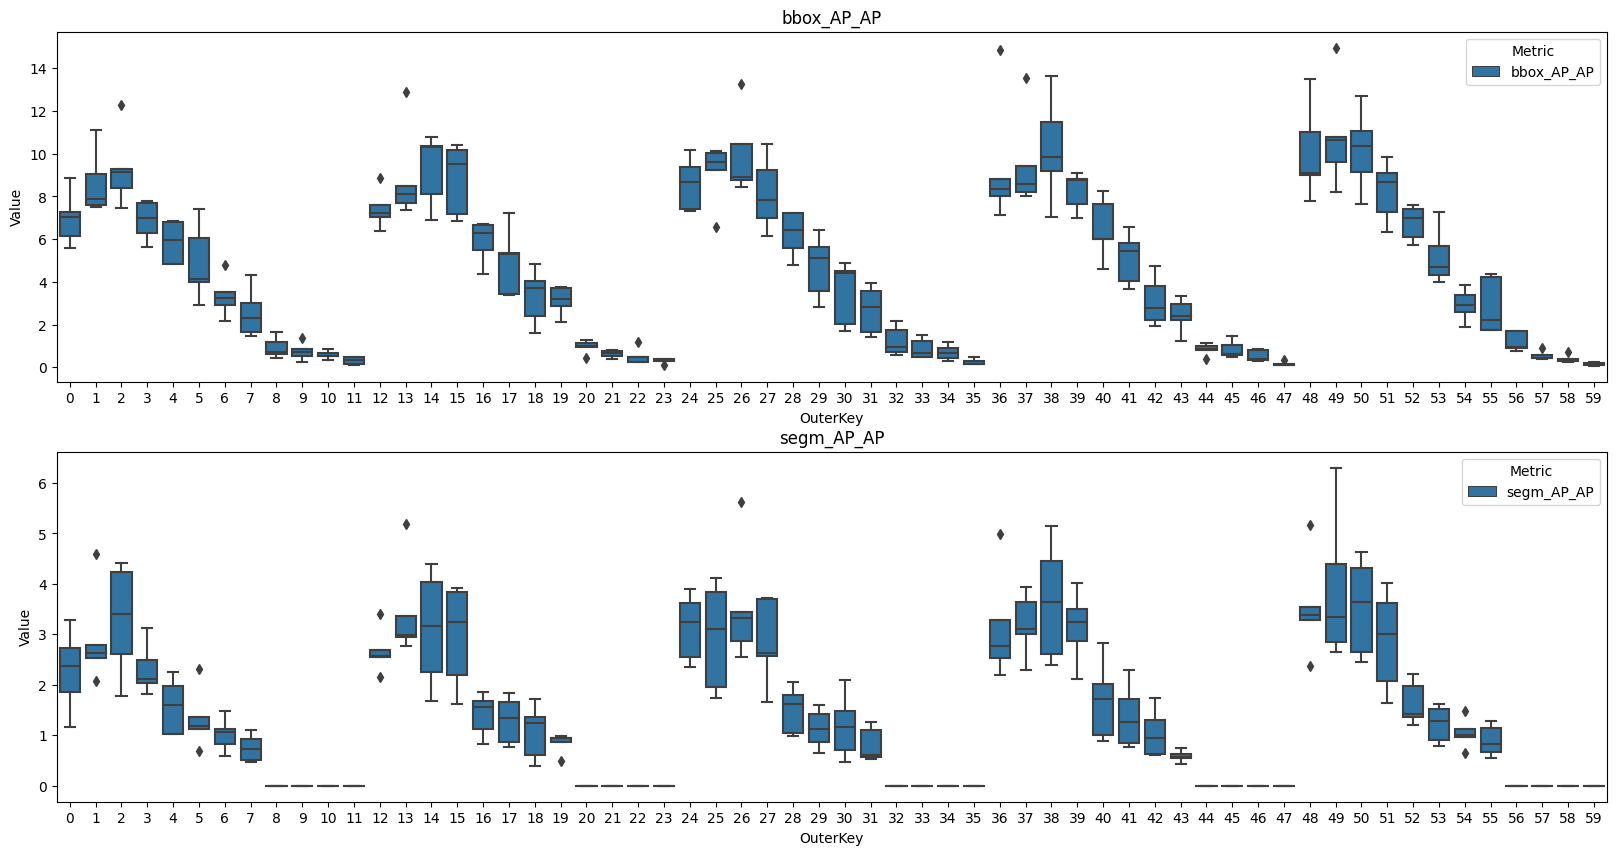

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

melted_bbox_df = data_df_bbox.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_bbox_df, hue='Metric', ax=ax[0])
ax[0].set_title('bbox_AP_AP')
ax[0].set_xlabel('OuterKey')
ax[0].set_ylabel('Value')

melted_segm_df = data_df_segm.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_segm_df, hue='Metric', ax=ax[1])
ax[1].set_title('segm_AP_AP')
ax[1].set_xlabel('OuterKey')
ax[1].set_ylabel('Value')

In [14]:
# Save a new df for sections of 12 rows of oute key of grouped_bbox_data_bbox_df
grouped_bbox_data_0_11 = grouped_data_bbox_df[0:12]
grouped_bbox_data_12_23 = grouped_data_bbox_df[12:24]
grouped_bbox_data_24_35 = grouped_data_bbox_df[24:36]
grouped_bbox_data_36_47 = grouped_data_bbox_df[36:48]
grouped_bbox_data_48_59 = grouped_data_bbox_df[48:60]
print(grouped_bbox_data_0_11.shape, grouped_bbox_data_24_35.shape, grouped_bbox_data_36_47.shape, grouped_bbox_data_48_59.shape)
grouped_bbox_data_0_11.head()

(12, 8) (12, 8) (12, 8) (12, 8)


bbox_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  6.980781  1.252314  5.591912  6.135806  7.033884   
1               5.0  8.634870  1.519559  7.524564  7.601979  7.873111   
2               5.0  9.298117  1.809666  7.439970  8.394946  9.128211   
3               5.0  6.881601  0.911931  5.646898  6.305493  6.986565   
4               5.0  5.863682  0.989913  4.851425  4.852186  5.958952   

                               
               75%        max  
OuterKey                       
0         7.280715   8.861588  
1         9.053679  11.121016  
2         9.262693  12.264766  
3         7.689176   7.779871  
4         6.787154   6.868692

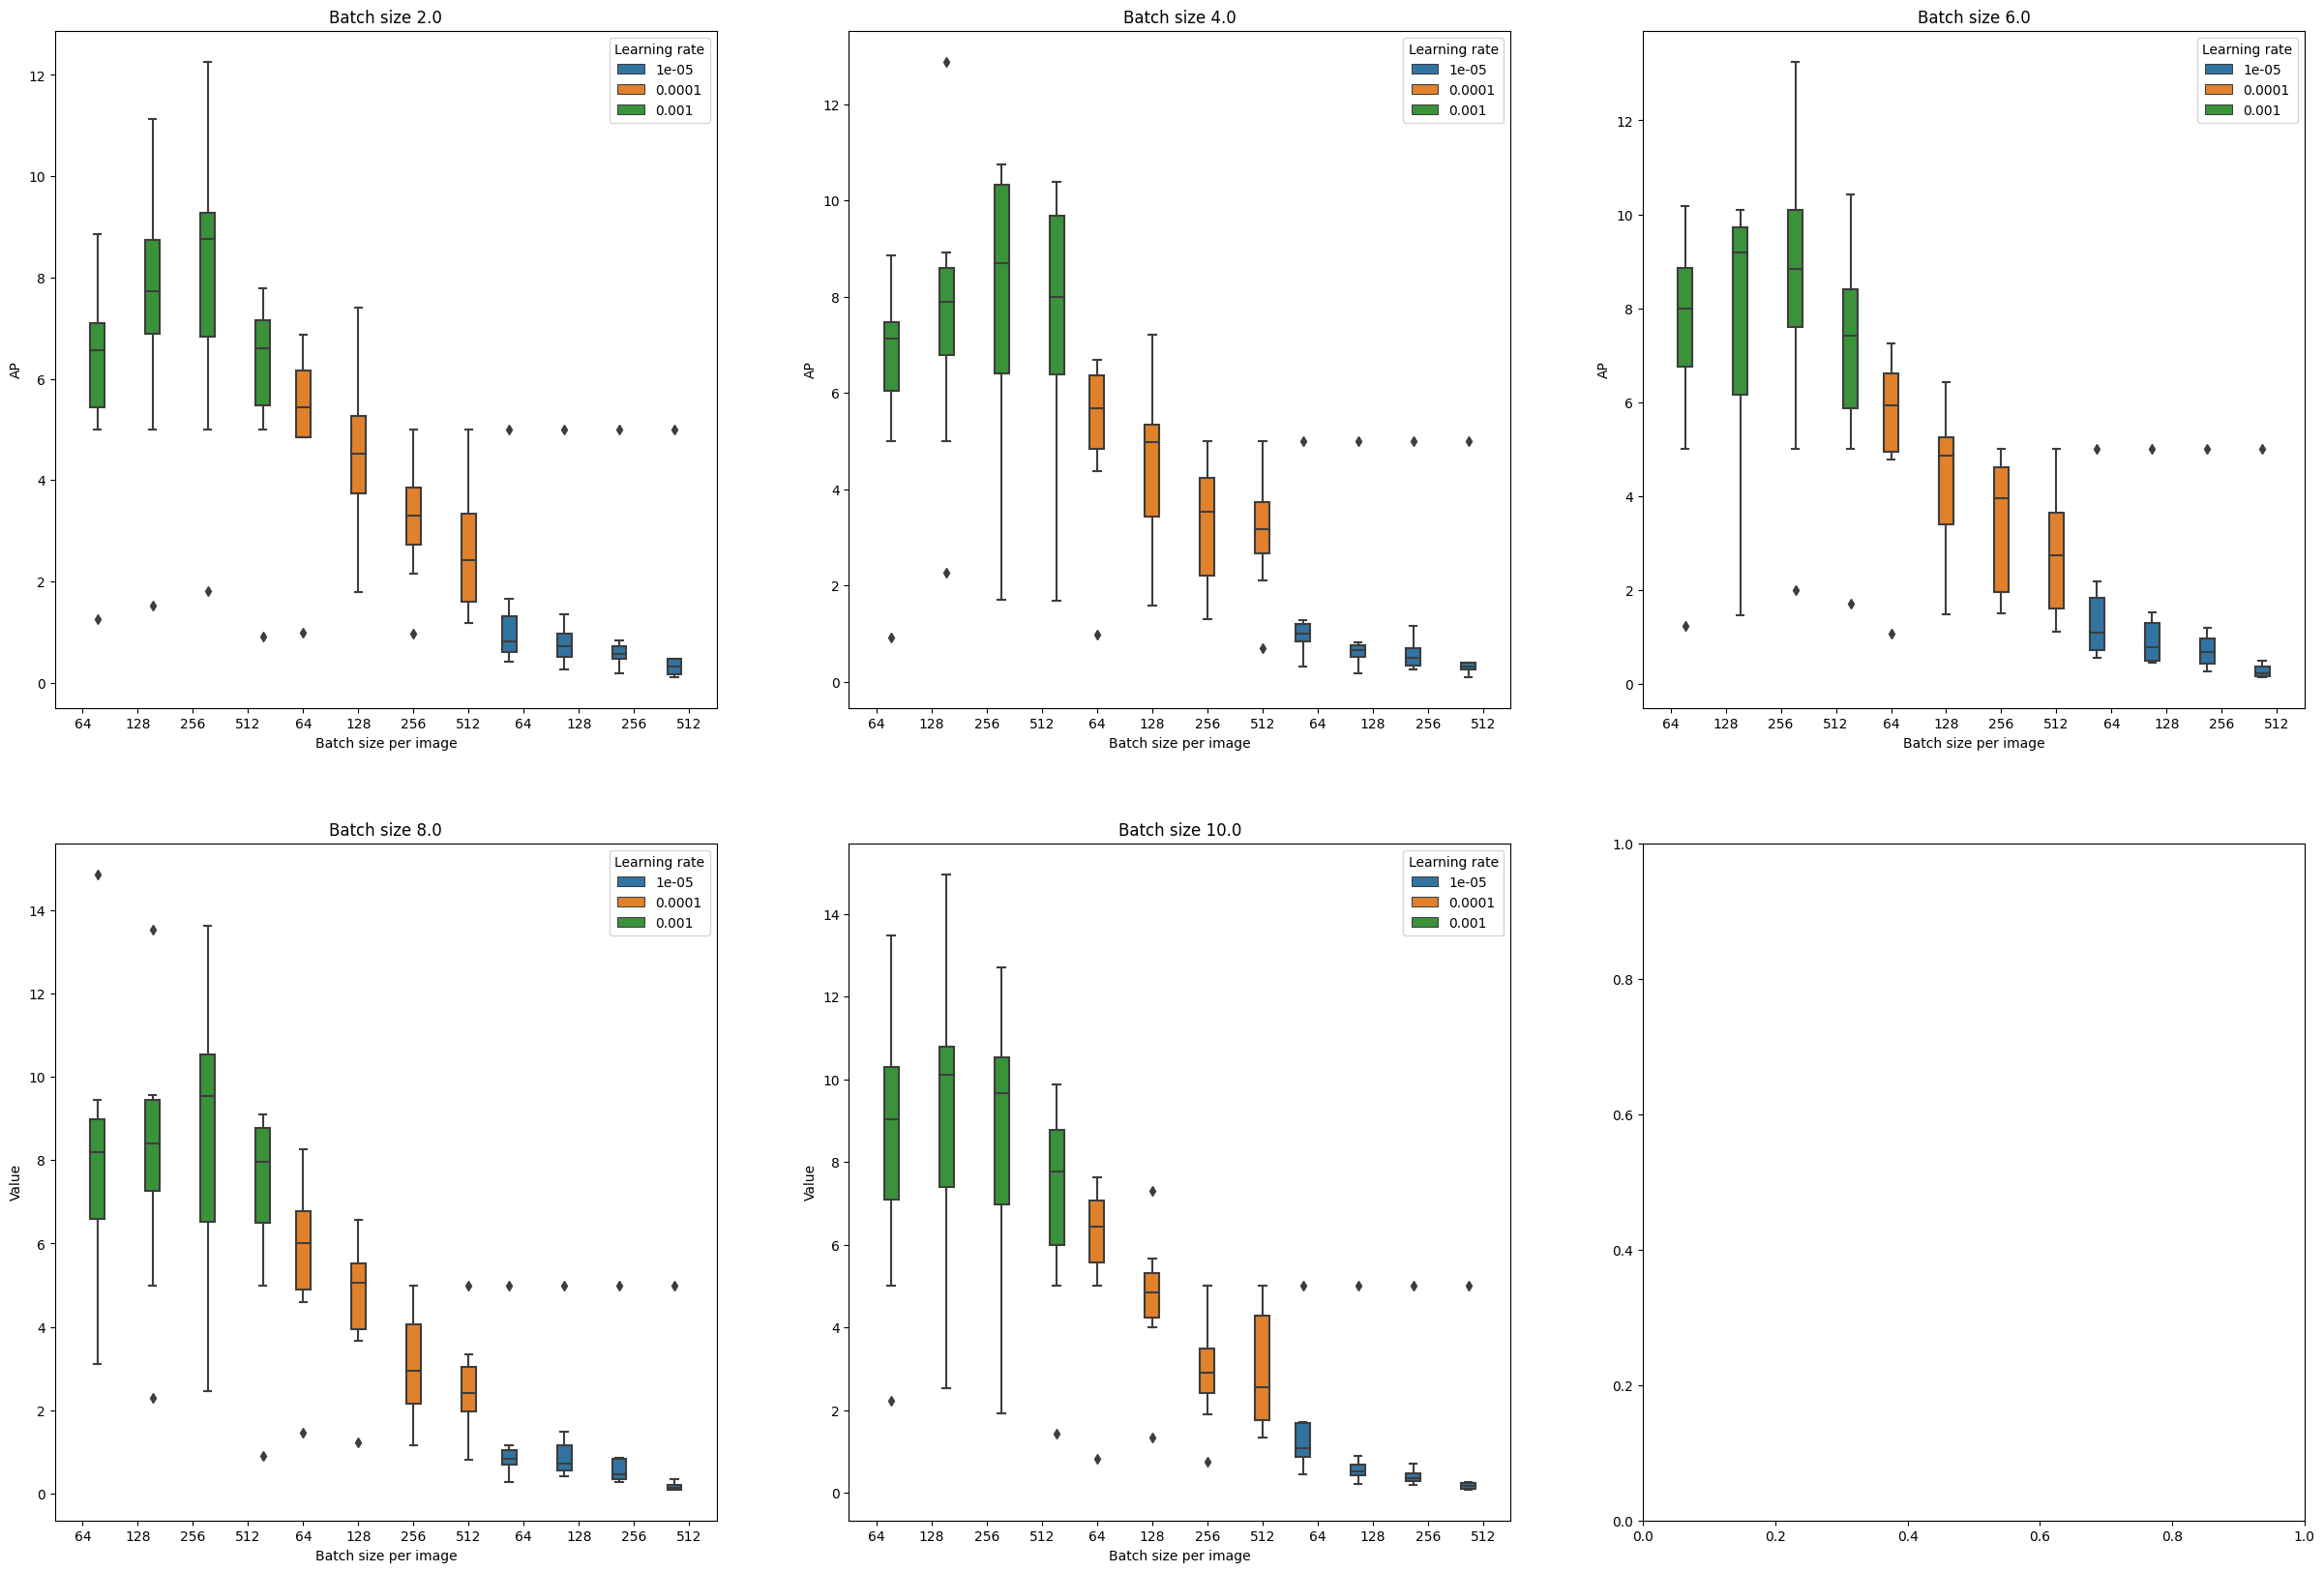

In [15]:
x_value = [64,128,256,512]*3
x_values_df = pd.DataFrame(x_value, columns=['Batch size per image'])

hue_labels = [0.001, 0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001, 0.0001, 0.00001, 0.00001, 0.00001, 0.00001]

fig, ax = plt.subplots(2, 3, figsize=(30, 20))

melt_bbox_0_11 = grouped_bbox_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_0_11['Learning rate'] = melt_bbox_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_0_11, hue='Learning rate', ax=ax[0][0])
ax[0][0].set_xticklabels(x_values_df['Batch size per image'])
ax[0][0].set_xlabel('Batch size per image')
ax[0][0].set_ylabel('AP')
ax[0][0].set_title('Batch size 2.0')

melt_bbox_12_23 = grouped_bbox_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_12_23['Learning rate'] = melt_bbox_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=12)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_12_23, hue='Learning rate', ax=ax[0][1])
ax[0][1].set_title('Batch size 4.0')
ax[0][1].set_xticklabels(x_values_df['Batch size per image'])
ax[0][1].set_xlabel('Batch size per image')
ax[0][1].set_ylabel('AP')

melt_bbox_24_35 = grouped_bbox_data_24_35.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_24_35['Learning rate'] = melt_bbox_24_35['OuterKey'].map(dict(enumerate(hue_labels,start=24)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_24_35, hue='Learning rate', ax=ax[0][2])
ax[0][2].set_title('Batch size 6.0')
ax[0][2].set_xticklabels(x_values_df['Batch size per image'])
ax[0][2].set_xlabel('Batch size per image')
ax[0][2].set_ylabel('AP')

melt_bbox_36_47 = grouped_bbox_data_36_47.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_36_47['Learning rate'] = melt_bbox_36_47['OuterKey'].map(dict(enumerate(hue_labels, start=36)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_36_47, hue='Learning rate', ax=ax[1][0])
ax[1][0].set_title('Batch size 8.0')
ax[1][0].set_xticklabels(x_values_df['Batch size per image'])
ax[1][0].set_xlabel('Batch size per image')

melt_bbox_48_59 = grouped_bbox_data_48_59.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_48_59['Learning rate'] = melt_bbox_48_59['OuterKey'].map(dict(enumerate(hue_labels, start=48)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_48_59, hue='Learning rate', ax=ax[1][1])
ax[1][1].set_title('Batch size 10.0')
ax[1][1].set_xticklabels(x_values_df['Batch size per image'])
ax[1][1].set_xlabel('Batch size per image')

plt.show()


In [16]:
grouped_segm_data_0_11 = grouped_data_segm_df[0:12]
grouped_segm_data_12_23 = grouped_data_segm_df[12:24]
grouped_segm_data_24_35 = grouped_data_segm_df[24:36]
grouped_segm_data_36_47 = grouped_data_segm_df[36:48]
grouped_segm_data_48_59 = grouped_data_segm_df[48:60]
print(grouped_segm_data_0_11.shape, grouped_segm_data_24_35.shape, grouped_segm_data_36_47.shape, grouped_segm_data_48_59.shape)
grouped_segm_data_0_11.head()

(12, 8) (12, 8) (12, 8) (12, 8)


segm_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  2.284272  0.813768  1.167343  1.856641  2.378872   
1               5.0  2.926413  0.971810  2.070217  2.535489  2.639971   
2               5.0  3.285799  1.112225  1.774311  2.602790  3.398075   
3               5.0  2.318847  0.514851  1.815244  2.041576  2.117670   
4               5.0  1.577873  0.557413  1.020691  1.022883  1.608711   

                              
               75%       max  
OuterKey                      
0         2.727890  3.290615  
1         2.789363  4.597022  
2         4.235655  4.418164  
3         2.488072  3.131671  
4         1.979288  2.257791

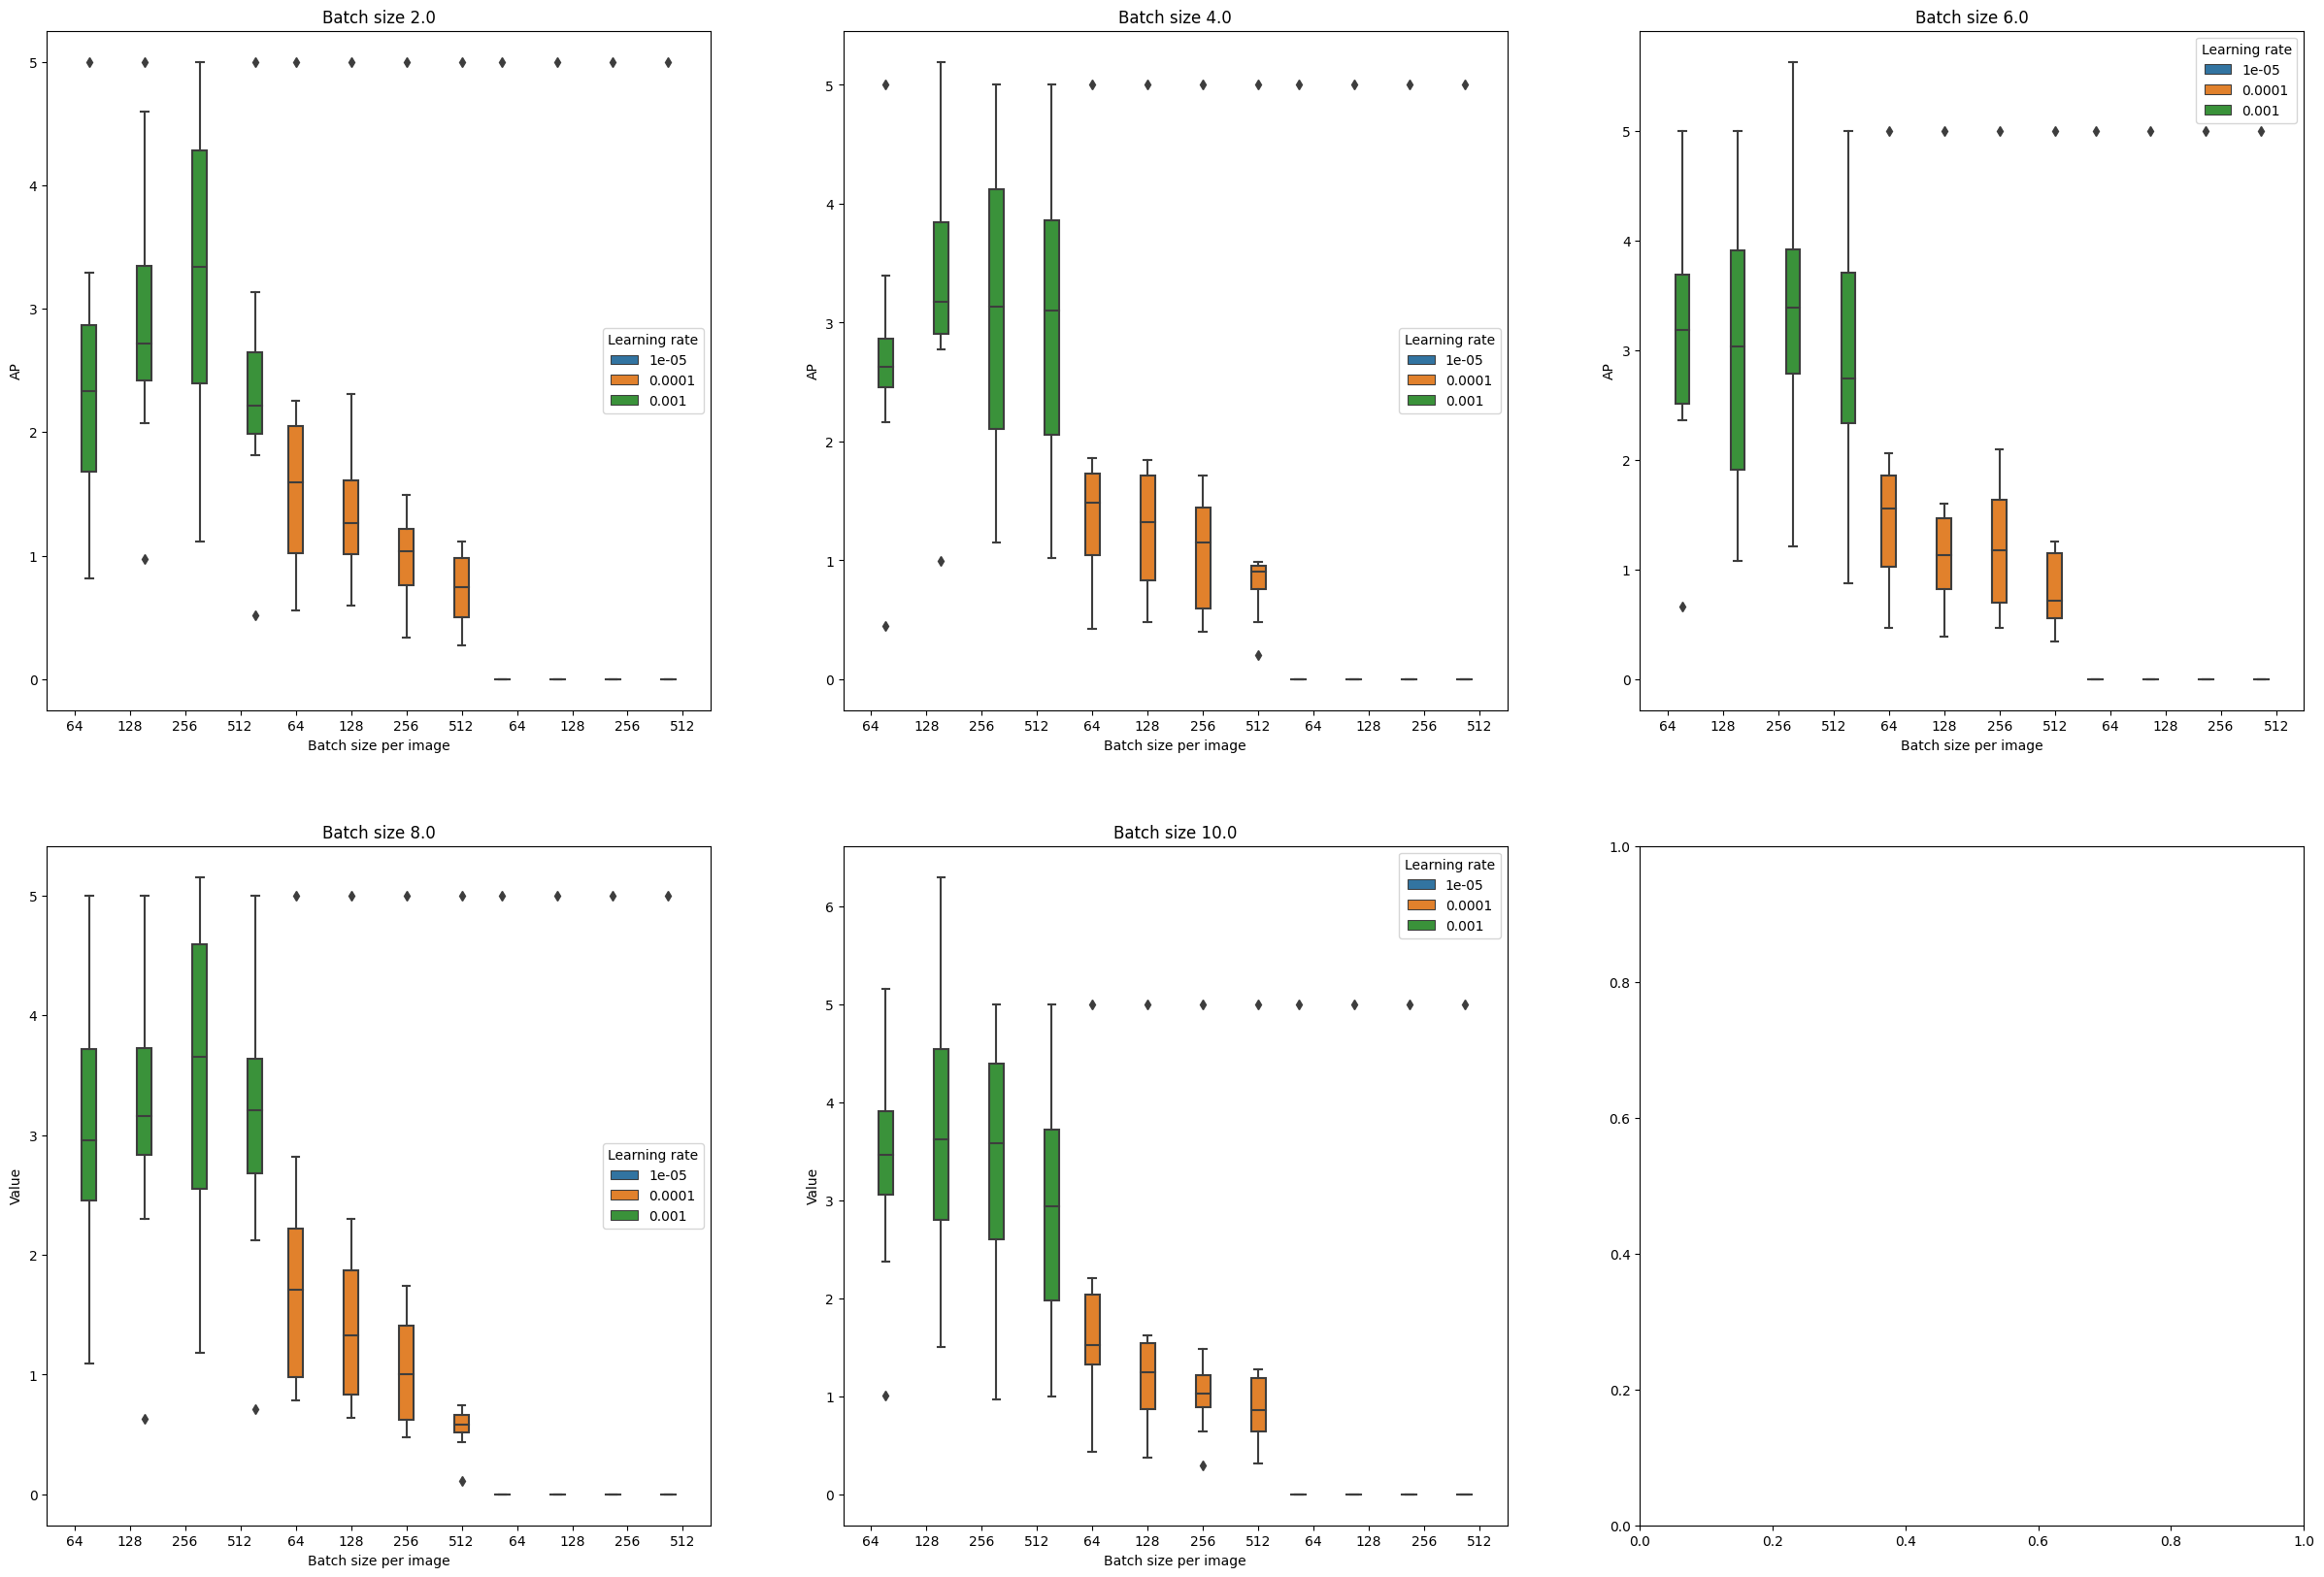

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

melt_segm_0_11 = grouped_segm_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_0_11['Learning rate'] = melt_segm_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_0_11, hue='Learning rate', ax=ax[0][0])
ax[0][0].set_xticklabels(x_values_df['Batch size per image'])
ax[0][0].set_xlabel('Batch size per image')
ax[0][0].set_ylabel('AP')
ax[0][0].set_title('Batch size 2.0')

melt_segm_12_23 = grouped_segm_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_12_23['Learning rate'] = melt_segm_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=12)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_12_23, hue='Learning rate', ax=ax[0][1])
ax[0][1].set_title('Batch size 4.0')
ax[0][1].set_xticklabels(x_values_df['Batch size per image'])
ax[0][1].set_xlabel('Batch size per image')
ax[0][1].set_ylabel('AP')

melt_segm_24_35 = grouped_segm_data_24_35.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_24_35['Learning rate'] = melt_segm_24_35['OuterKey'].map(dict(enumerate(hue_labels,start=24)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_24_35, hue='Learning rate', ax=ax[0][2])
ax[0][2].set_title('Batch size 6.0')
ax[0][2].set_xticklabels(x_values_df['Batch size per image'])
ax[0][2].set_xlabel('Batch size per image')
ax[0][2].set_ylabel('AP')

melt_segm_36_47 = grouped_segm_data_36_47.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_36_47['Learning rate'] = melt_segm_36_47['OuterKey'].map(dict(enumerate(hue_labels, start=36)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_36_47, hue='Learning rate', ax=ax[1][0])
ax[1][0].set_title('Batch size 8.0')
ax[1][0].set_xticklabels(x_values_df['Batch size per image'])
ax[1][0].set_xlabel('Batch size per image')

melt_segm_48_59 = grouped_segm_data_48_59.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_48_59['Learning rate'] = melt_segm_48_59['OuterKey'].map(dict(enumerate(hue_labels, start=48)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_48_59, hue='Learning rate', ax=ax[1][1])
ax[1][1].set_title('Batch size 10.0')
ax[1][1].set_xticklabels(x_values_df['Batch size per image'])
ax[1][1].set_xlabel('Batch size per image')

plt.show()


From the following graphs, we can extract that, as the performance increases, the variance of the results also increases. This is expected in neural networls as they are a high variance model.

# Metrics

In [18]:
import os
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator

def convert_tb_data(root_dir, sort_by=None):
    def convert_tfevent(filepath):
        return pd.DataFrame([parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )

    columns_order = ['wall_time', 'name', 'step', 'value']
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by:
        all_df = all_df.sort_values(by=sort_by)
    return all_df


2024-04-01 11:38:28.473962: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [19]:
model_38_0 = convert_tb_data("./../models/Glass_models/38_5000/0")
model_38_1 = convert_tb_data("./../models/Glass_models/38_5000/1")
model_38_2 = convert_tb_data("./../models/Glass_models/38_5000/2")
model_38_3 = convert_tb_data("./../models/Glass_models/38_5000/3")
model_38_4 = convert_tb_data("./../models/Glass_models/38_5000/4")
model_38_0.head()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


,wall_time,name,step,value
0,1.708340e+09,data_time,18,0.195069
1,1.708340e+09,rpn/num_pos_anchors,19,5.562500
2,1.708340e+09,rpn/num_neg_anchors,19,250.437500
3,1.708340e+09,roi_head/num_fg_samples,19,6.812500
4,1.708340e+09,roi_head/num_bg_samples,19,249.187500


In [20]:
model_50_0 = convert_tb_data("./../models/Glass_models/49_5000/0")
model_50_1 = convert_tb_data("./../models/Glass_models/49_5000/1")
model_50_2 = convert_tb_data("./../models/Glass_models/49_5000/2")
model_50_3 = convert_tb_data("./../models/Glass_models/49_5000/3")
model_50_4 = convert_tb_data("./../models/Glass_models/49_5000/4")
model_50_0.head()

,wall_time,name,step,value
0,1.708085e+09,data_time,18,0.245687
1,1.708085e+09,rpn/num_pos_anchors,19,6.200000
2,1.708085e+09,rpn/num_neg_anchors,19,249.800003
3,1.708085e+09,roi_head/num_fg_samples,19,7.350000
4,1.708085e+09,roi_head/num_bg_samples,19,120.650002


In [21]:
model_38_0_metrics = model_38_0.pivot(index='step', columns='name', values='value')
model_38_0_metrics = model_38_0_metrics.dropna(how='all')
model_38_0_metrics_eval = model_38_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_1_metrics = model_38_1.pivot(index='step', columns='name', values='value')
model_38_1_metrics = model_38_1_metrics.dropna(how='all')
model_38_1_metrics_eval = model_38_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_2_metrics = model_38_2.pivot(index='step', columns='name', values='value')
model_38_2_metrics = model_38_2_metrics.dropna(how='all')
model_38_2_metrics_eval = model_38_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_3_metrics = model_38_3.pivot(index='step', columns='name', values='value')
model_38_3_metrics = model_38_3_metrics.dropna(how='all')
model_38_3_metrics_eval = model_38_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_4_metrics = model_38_4.pivot(index='step', columns='name', values='value')
model_38_4_metrics = model_38_4_metrics.dropna(how='all')
model_38_4_metrics_eval = model_38_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

In [22]:
model_50_0_metrics = model_50_0.pivot(index='step', columns='name', values='value')
model_50_0_metrics = model_50_0_metrics.dropna(how='all')
model_50_0_metrics_eval = model_50_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_1_metrics = model_50_1.pivot(index='step', columns='name', values='value')
model_50_1_metrics = model_50_1_metrics.dropna(how='all')
model_50_1_metrics_eval = model_50_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_2_metrics = model_50_2.pivot(index='step', columns='name', values='value')
model_50_2_metrics = model_50_2_metrics.dropna(how='all')
model_50_2_metrics_eval = model_50_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_3_metrics = model_50_3.pivot(index='step', columns='name', values='value')
model_50_3_metrics = model_50_3_metrics.dropna(how='all')
model_50_3_metrics_eval = model_50_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_4_metrics = model_50_4.pivot(index='step', columns='name', values='value')
model_50_4_metrics = model_50_4_metrics.dropna(how='all')
model_50_4_metrics_eval = model_50_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_0_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,0.500122,1.408080,0.152072,0.190879,1.314686,1.034730,NaN,2267.260010,0.960693,1.000000,...,249.750,6.250,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.466594,0.726050
199,1.186699,2.867444,0.784296,1.728172,2.003303,2.223896,NaN,2265.668213,0.946533,0.974992,...,251.375,4.625,0.013870,0.069694,0.004633,0.0,0.212164,0.021766,0.594343,0.551791
299,1.873276,4.326808,1.416521,3.265465,2.691921,3.413061,NaN,2455.771484,0.958008,0.538376,...,249.375,6.625,0.027739,0.139389,0.009266,0.0,0.424328,0.043532,0.662685,0.494037
399,2.515411,5.281499,2.098583,5.397746,3.014163,4.336461,NaN,2522.928467,0.962646,0.329127,...,250.625,5.375,0.469893,1.619829,0.078615,0.0,9.480663,0.320651,0.610433,0.410334
499,3.157546,6.236189,2.780646,7.530026,3.336406,5.259860,NaN,2378.828613,0.970947,0.230069,...,250.500,5.500,0.912047,3.100269,0.147965,0.0,18.536999,0.597769,0.583131,0.333740


In [23]:
model_38_avg_metrics = (model_38_0_metrics + model_38_1_metrics + model_38_2_metrics + model_38_3_metrics + model_38_4_metrics) / 5
model_38_avg_metrics_eval = model_38_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_38_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,0.494315,1.325696,0.240519,0.262797,1.291227,0.482856,NaN,3688.028027,0.963623,1.000000,...,249.9250,6.0750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.731549,0.708657
199,1.101825,2.809510,0.532610,1.781934,2.093740,1.229423,NaN,3598.807617,0.946240,0.988145,...,250.7875,5.2125,0.007549,0.033858,0.001173,0.000000,0.082037,0.013066,0.771714,0.565627
299,1.709334,4.293324,0.824701,3.301072,2.896253,1.975989,NaN,3570.233447,0.959863,0.549436,...,249.9250,6.0750,0.015098,0.067717,0.002345,0.000000,0.164074,0.026133,0.780834,0.491127
399,2.301340,5.308954,1.325492,4.243701,3.425168,2.768461,NaN,3527.559521,0.964795,0.347335,...,250.1750,5.8250,0.400402,1.447144,0.051816,0.397360,6.916702,0.238685,0.810359,0.414820
499,2.893347,6.324583,1.826283,5.186329,3.954082,3.560934,NaN,3420.495557,0.969287,0.235964,...,250.1750,5.8250,0.785706,2.826572,0.101286,0.794719,13.669332,0.451237,0.771621,0.345003


In [24]:
model_50_avg_metrics = (model_50_0_metrics + model_50_1_metrics + model_50_2_metrics + model_50_3_metrics + model_50_4_metrics) / 5
model_50_avg_metrics_eval = model_50_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_50_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,0.655042,1.865682,0.258801,0.668559,1.254971,0.979816,NaN,5263.028906,0.916953,1.000000,...,250.250000,5.75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.117383,0.947428
199,1.322694,3.531014,0.537250,2.219339,2.150475,1.697548,NaN,5321.598340,0.923750,0.491107,...,250.199997,5.80,0.008554,0.037296,0.000494,0.000000,0.049505,0.015137,1.206571,0.828470
299,1.990347,5.196347,0.815700,3.524381,3.045978,2.415281,NaN,5234.166797,0.936641,0.208476,...,250.129999,5.87,0.017108,0.074592,0.000988,0.000000,0.099010,0.030275,1.183892,0.638133
399,3.054115,6.780840,2.143353,5.096448,4.351205,3.456180,NaN,5196.757520,0.949297,0.139404,...,249.769998,6.23,0.548332,1.853557,0.084525,0.601295,6.236335,0.390121,1.146409,0.474734
499,4.117883,8.365333,3.471005,6.668515,5.656432,4.497079,NaN,5114.401855,0.957031,0.094608,...,250.120001,5.88,1.079555,3.632522,0.168062,1.202590,12.373660,0.749968,1.164748,0.417415


In [25]:
model_50_avg_metrics.columns

Index(['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APl', 'bbox/APm', 'bbox/APs',
       'data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy',
       'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'loss_box_reg',
       'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr',
       'mask_rcnn/accuracy', 'mask_rcnn/false_negative',
       'mask_rcnn/false_positive', 'roi_head/num_bg_samples',
       'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors',
       'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APl', 'segm/APm', 'segm/APs',
       'time', 'total_loss'],
      dtype='object', name='name')

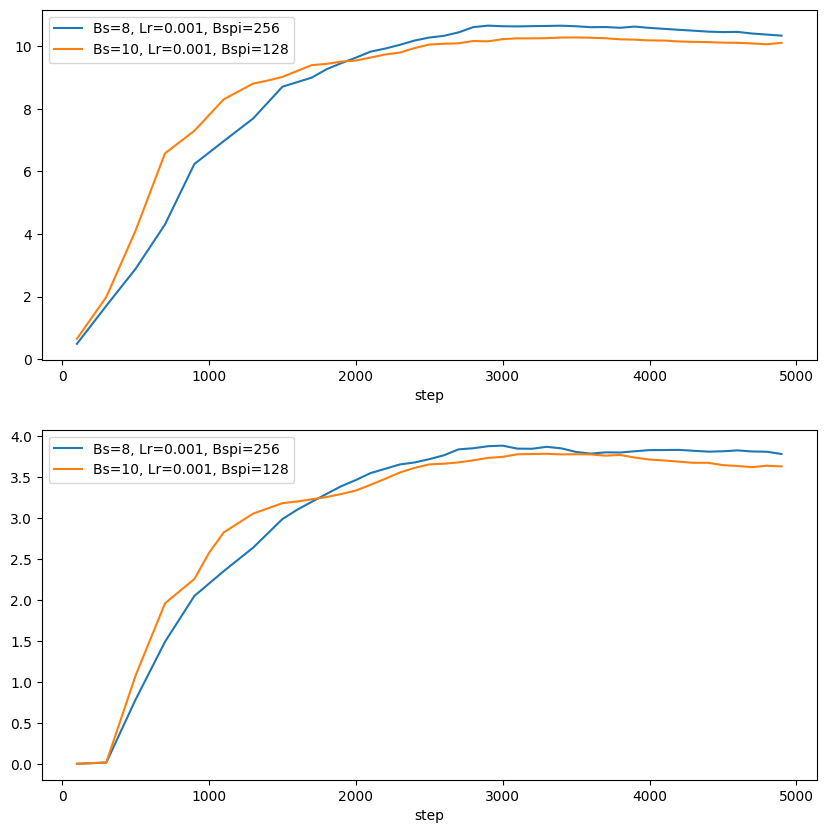

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

model_38_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0], label='Bs=8, Lr=0.001, Bspi=256')
model_50_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0], label='Bs=10, Lr=0.001, Bspi=128')
model_38_avg_metrics_eval.plot(y='segm/AP', ax=ax[1], label='Bs=8, Lr=0.001, Bspi=256')
model_50_avg_metrics_eval.plot(y='segm/AP', ax=ax[1], label='Bs=10, Lr=0.001, Bspi=128')

plt.show()

Comparing both models when trained up to 5000 epochs, we can observe that in both cases model 38 is the best performing. 

## Overfitting

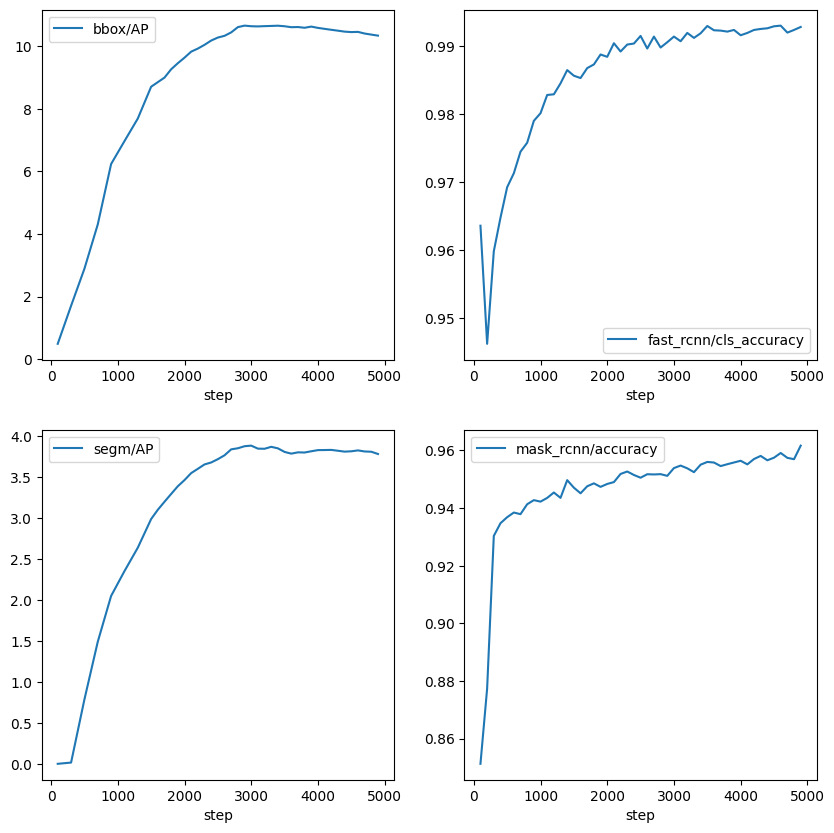

In [27]:
# Plot the curve of the average of model 50 that compares bbox/AP to fast_rcnn/cls_accuracy and segm/AP to mask_rcnn/accuracy, set log scale on the y-axis
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

model_38_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0][0], label='bbox/AP')
model_38_avg_metrics_eval.plot(y='fast_rcnn/cls_accuracy', ax=ax[0][1], label='fast_rcnn/cls_accuracy')

model_38_avg_metrics_eval.plot(y='segm/AP', ax=ax[1][0], label='segm/AP')
model_38_avg_metrics_eval.plot(y='mask_rcnn/accuracy', ax=ax[1][1], label='mask_rcnn/accuracy')

plt.show()

From comparing training and evaluation curves, we can clearly see that around epoch 3000 the model starts overfitting as the training loss keeps decreasing while the evaluation loss starts increasing. This means that the final model should be trained up to 3000 epochs.

In [28]:

final_model_epoch_3000 = model_38_0_metrics_eval.iloc[29]
final_model_epoch_3000

name
bbox/AP                        10.161775
bbox/AP50                      14.829089
bbox/AP75                      11.249963
bbox/APl                       18.186604
bbox/APm                       10.289894
bbox/APs                        9.471045
data_time                            NaN
eta_seconds                  1835.069580
fast_rcnn/cls_accuracy          0.991943
fast_rcnn/false_negative        0.049357
fast_rcnn/fg_cls_accuracy       0.945259
loss_box_reg                    0.045398
loss_cls                        0.020916
loss_mask                       0.109496
loss_rpn_cls                    0.002360
loss_rpn_loc                    0.005062
lr                              0.001000
mask_rcnn/accuracy              0.952560
mask_rcnn/false_negative        0.158214
mask_rcnn/false_positive        0.025059
roi_head/num_bg_samples       240.312500
roi_head/num_fg_samples        15.687500
rpn/num_neg_anchors           249.437500
rpn/num_pos_anchors             6.562500
segm/AP    

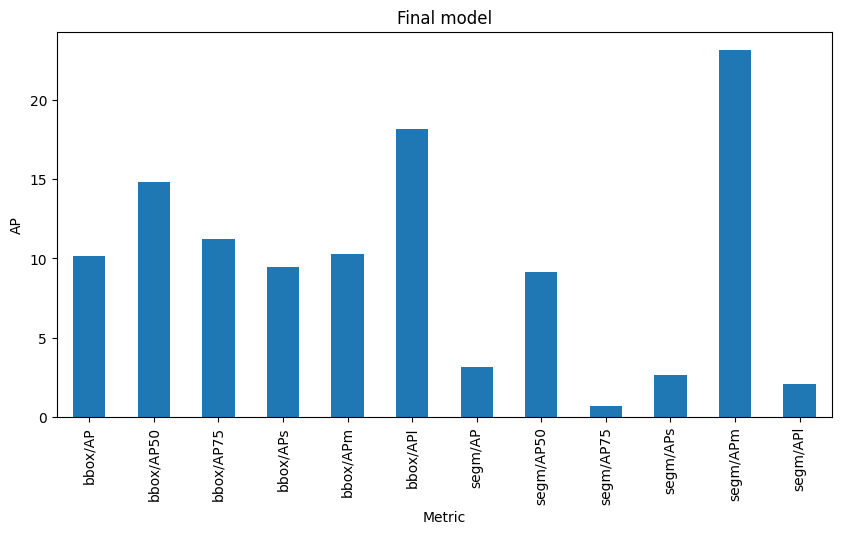

In [29]:
# Bar plot for the final model at epoch 3500
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

final_model_epoch_3000[['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl', 'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl']].plot(kind='bar', ax=ax)
ax.set_title('Final model')
ax.set_ylabel('AP')
ax.set_xlabel('Metric')

plt.show()

# Final model

For our final model we will use the following hyperparameters: bs=8.0, lr=0.001, bspi=256 and 3000 epochs traiend on all data.

In [30]:
final_model = convert_tb_data("./../models/Glass_models/38_3000")
final_model.head()

ValueError: No objects to concatenate

In [ ]:
final_model_metrics = final_model.pivot(index='step', columns='name', values='value')
final_model_metrics = final_model_metrics.drop(columns=['data_time'])
final_model_metrics = final_model_metrics.dropna(how='all') 
final_model_metrics.head()

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10, 10))

final_model_metrics.plot(y='loss_cls', ax=ax[0][0], label='loss_cls')
final_model_metrics.plot(y='loss_mask', ax=ax[0][1], label='loss_mask')
final_model_metrics.plot(y='loss_rpn_cls', ax=ax[1][0], label='loss_rpn_cls')
final_model_metrics.plot(y='loss_rpn_loc', ax=ax[1][1], label='loss_rpn_loc')
final_model_metrics.plot(y='loss_box_reg', ax=ax[2][0], label='loss_box_reg')
final_model_metrics.plot(y='total_loss', ax=ax[2][1], label='total_loss')


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

final_model_metrics.plot(y='mask_rcnn/accuracy', ax=ax[0], label='mask_rcnn/accuracy')
final_model_metrics.plot(y='fast_rcnn/cls_accuracy', ax=ax[1], label='fast_rcnn/cls_accuracy')

plt.show()